In [70]:
#%pip install torch torchvision torchaudio
#%pip install scipy
#%pip install torch
#%pip install pyinform

import pandas as pd
import numpy as np
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pyinform.transferentropy import transfer_entropy 
from tqdm import tqdm
from arch import arch_model
import statsmodels.api as sm

In [71]:
#Switch (to run the sentiment part)
Switch = False

### Helper functions

In [72]:
#Helper function to read the desired file
def read_file(file_path):

    file_extension = file_path.split('.')[-1].lower()

    try:
        if file_extension == 'csv':
            # Read CSV file
            df = pd.read_csv(file_path)
        elif file_extension == 'parquet':
            # Read Parquet file
            df = pd.read_parquet(file_path)
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")
    except Exception as e:
        raise ValueError(f"Error reading file: {e}")

    return df


In [73]:
#Helper function to write the desired file
def write_file(df, file_path):

    file_extension = file_path.split('.')[-1].lower()

    try:
        if file_extension == 'csv':
            # Write to CSV
            df.to_csv(file_path, index=False)
        elif file_extension == 'parquet':
            # Write to Parquet
            df.to_parquet(file_path, engine="pyarrow", index=False)
        else:
            raise ValueError(f"Unsupported file type: {file_extension}")
    except Exception as e:
        raise ValueError(f"Error writing file: {e}")


In [74]:
#Helper function to filter the DataFrame to only include rows where 'Article_title' contains the name or ticker
def cleaner_df(df, ticker_lst):
    
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # Extract the original company name and ticker from the list
    org_company_name = ticker_lst[0]
    ticker = ticker_lst[1]
    pattern = rf'\b({org_company_name}|{ticker})\b'
    # Filter the DataFrame to only include rows where 'Article_title' contains the name or ticker
    df_filtered = df[df['Article_title'].str.contains(pattern, case=False, na=False)]
    
    return df_filtered

In [75]:
#Pipeline generator function
def optimization_pipeline(df, transformations):
    for func, kwargs in transformations:
        df = func(df, **kwargs)
    return df

### 0. Cleaning our data

In [76]:
#Applying the function
#First choose what dataset we want to clean.
#I want us to first work with Apple news dataset but we could work with any dataset (just replace the path)
df_to_clean = read_file("../data/raw/AAPL_news.parquet")
df_to_clean.head()

,Date,Stock_symbol,Article_title
0,2023-12-16 22:00:00,AAPL,My 6 Largest Portfolio Holdings Heading Into 2...
1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...
2,2023-12-16 21:00:00,AAPL,"Company News for Dec 19, 2023"
3,2023-12-16 21:00:00,AAPL,NVIDIA (NVDA) Up 243% YTD: Will It Carry Momen...
4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,..."


  - Incorporate sentiment analysis with DisRoberta to generate sentiment scores

In [77]:
#function applied
df_filtered = cleaner_df(df_to_clean, ticker_lst = ["Apple","AAPL"])
df_filtered.head()

C:\Users\Mert\AppData\Local\Temp\ipykernel_46148\675279999.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtered = df[df['Article_title'].str.contains(pattern, case=False, na=False)]


,Date,Stock_symbol,Article_title
1,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...
4,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,..."
6,2023-12-16 20:00:00,AAPL,AAPL Quantitative Stock Analysis
15,2023-12-16 04:00:00,AAPL,"After Hours Most Active for Dec 18, 2023 : PAC..."
16,2023-12-16 04:00:00,AAPL,"Technology Sector Update for 12/18/2023: PCT, ..."


In [78]:
#Finally, save the cleaned dataset
#If we work with another dataset, change the path
write_file(df_filtered,"../data/clean/apple_news_c.csv")

### 1. News-data Preprocessing

**Here we start our data processing work to convert get the sentiment**

Assume that the dataset of the news is a constant flow of the news, then we try to construct a stochastic process on sentiment: use distrillroberta to generate sentiment(positive, neutral, negative) of the news headline and labelled the as (1, 0, -1) scores. Note that the news are always released in two ways: one is that the news are released at **midnight(or non-trading time) in batches**, the others are released during **trading time without batches(flow-released news)**. For batch-released news, average the sentiment score.

THe formula for the stochastic process is be written as 

$$
I_t^s = \sum_{j} g(f(e_{jt}^{s})), 
g(x) = \begin{cases} 1, x = "Positive"\\
0, x = "Neutral"\\
-1, x = "Negative"\\
\end{cases},

f(x) = roBERTa(x),

$$

$f(x)$ is the pretrained sentiment classifier. $e_{jt}^{s}$ means the $j$-th embedding of the news headline at time $t$ for the stock $s$.

**Note**: time $t$ is not the natural time for trading, but it's proxy time interval between the new release, and it differs from stock to stock. Think of it as some sort of jump process.

In [79]:
cleaned_df = pd.read_csv("../data/clean/apple_news_c.csv")
cleaned_df.head()

,Date,Stock_symbol,Article_title
0,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...
1,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,..."
2,2023-12-16 20:00:00,AAPL,AAPL Quantitative Stock Analysis
3,2023-12-16 04:00:00,AAPL,"After Hours Most Active for Dec 18, 2023 : PAC..."
4,2023-12-16 04:00:00,AAPL,"Technology Sector Update for 12/18/2023: PCT, ..."


This script performs sentiment analysis on financial news articles using the PRE-TRAINED model we selected from Hugging Face.
The sentiment analysis model used is 'distilroberta-finetuned-financial-news-sentiment-analysis', which is fine-tuned on the financial_phrasebank dataset.

**Functions**:
 - **distill_roberta_classify_sentiment(article: str) -> int**:
        Classifies the sentiment of a given article as positive, negative, or neutral.
        Returns 1 for positive sentiment, -1 for negative sentiment, and 0 for neutral sentiment.

The script reads a DataFrame **cleaned_df** containing financial news articles, applies sentiment analysis to the 'Article_title' column,
and saves the resulting DataFrame with sentiment scores to a CSV file.

**Usage**:
    Ensure that the required libraries are installed and the input DataFrame **cleaned_df** is loaded.
    Run the script to perform sentiment analysis and save the results to a CSV file.


In [80]:
# We will use distilRoberta-financial-sentiment a fine-tuned version of distilroberta-base on the financial_phrasebank dataset
def distill_roberta_classify_sentiment(article):

    tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
    model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
    sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    sentiment_result = sentiment_pipeline(article)[0]
    label = sentiment_result['label']
    
    if label == "positive":
        return 1
    elif label == "negative":
        return -1
    else:
        return 0


# Now we need to merge the sentiment scores to the dataset (AND AFTER MERGE INDEX)
if Switch:
    cleaned_df['Sentiment'] = cleaned_df['Article_title'].apply(distill_roberta_classify_sentiment)
    #Writing the file
    write_file(cleaned_df,"../data/processed/processed_news_data_with_sent.csv")

### 2. Volatility-data preprocessing

#### Now that we have our data set with the sentiments, we want to link it to estimated volatility process

Discretize the tick-by-tick data to align with the news-data, by identifying the volatility of the price. When the batch news are released in non-trading time, assume that the traders in the market will react to the news as soon as the trading time starts, for flow-released news, assume that the market participants will react as soon as the information of the news is understood. There will be **one hyperparameter**:
  - The time-lag between the new release and the market reaction: $\gamma$

First, we estimate the **volatility process** with a GARCH(1,1) process after calculating the log returns as below:

$$
r_t = \mu + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma_t^2), \quad \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2.
$$


Set the volatility of the stock as **tranquil**, **steady** and **crisis** under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock volatility. The formula for the stochastic process of the discretized volatility can be written as: 

$$
\sigma_{t}^{s'} = h(\sigma_{t}^{s}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma, \delta > 0
$$

 - $\sigma_{t}^{s}$ is the estimated volatility of stock $s$ at time $t$ by GARCH(1,1)
 - $\sigma_{t}^{s'}$ is the discritized process of estimated volatility of stock $s$ at time $t$ by GARCH(1,1)





#### 2.1 Cleaning the price dataset

In [81]:
return_data = read_file("../data/quotes/apple_quotes.csv")
return_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1981,0.154018,0.155134,0.154018,0.154018,0.119849,21660800
1,05/01/1981,0.151228,0.151228,0.150670,0.150670,0.117244,35728000
2,06/01/1981,0.144531,0.144531,0.143973,0.143973,0.112032,45158400
3,07/01/1981,0.138393,0.138393,0.137835,0.137835,0.107256,55686400
4,08/01/1981,0.135603,0.135603,0.135045,0.135045,0.105085,39827200


In [82]:
# Calculate log returns
def calculate_log_returns(data, delta = 1, column_name='Close'):
    data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
    data['Log_Return'] = np.log(data[column_name] / data[column_name].shift(delta))
    data = data.dropna() 
    return data

In [83]:
#Calculating log returns and then inspecting the return dataframe 
returns_data = calculate_log_returns(return_data)
returns_data.head()

,Date,Close,Log_Return
1,05/01/1981,0.150670,-0.021977
2,06/01/1981,0.143973,-0.045466
3,07/01/1981,0.137835,-0.043568
4,08/01/1981,0.135045,-0.020449
5,09/01/1981,0.142299,0.052322


In [84]:
# Fit a GARCH(1,1) model
am = arch_model(returns_data['Log_Return'], vol='GARCH', p=1, q=1, dist='normal')
res = am.fit(disp='off')
# Extract the fitted conditional volatilities (time series)
returns_data['garch_vol'] = res.conditional_volatility

c:\Users\Mert\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008216. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [85]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                23922.3
Distribution:                  Normal   AIC:                          -47836.6
Method:            Maximum Likelihood   BIC:                          -47807.5
                                        No. Observations:                10607
Date:                Wed, Jan 22 2025   Df Residuals:                    10606
Time:                        18:53:01   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6170e-03  2.376e-04      6.806  1.002e-11 [1.

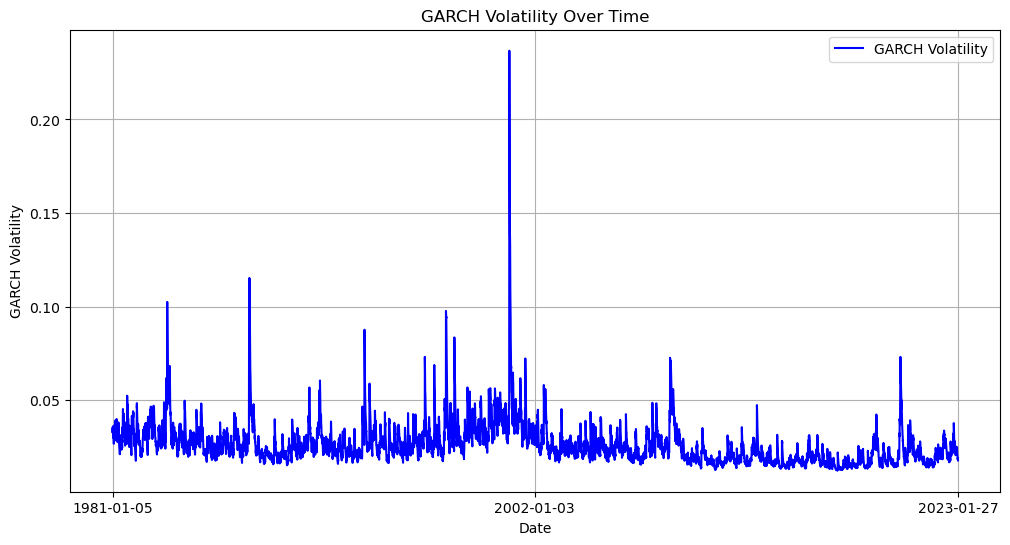

In [86]:
# Convert Date to datetime format with dayfirst=True
returns_data['Date'] = pd.to_datetime(returns_data['Date'], dayfirst=True)

# Determine the first, middle, and last date for x-ticks
first_date = returns_data['Date'].iloc[0]
middle_date = returns_data['Date'].iloc[len(returns_data) // 2]
last_date = returns_data['Date'].iloc[-1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(returns_data['Date'], returns_data['garch_vol'], label='GARCH Volatility', color='blue')

# Customizing the x-axis ticks
plt.xticks([first_date, middle_date, last_date], 
           [first_date.strftime('%Y-%m-%d'), 
            middle_date.strftime('%Y-%m-%d'), 
            last_date.strftime('%Y-%m-%d')])

# Adding labels, title, and legend
plt.xlabel('Date')
plt.ylabel('GARCH Volatility')
plt.title('GARCH Volatility Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


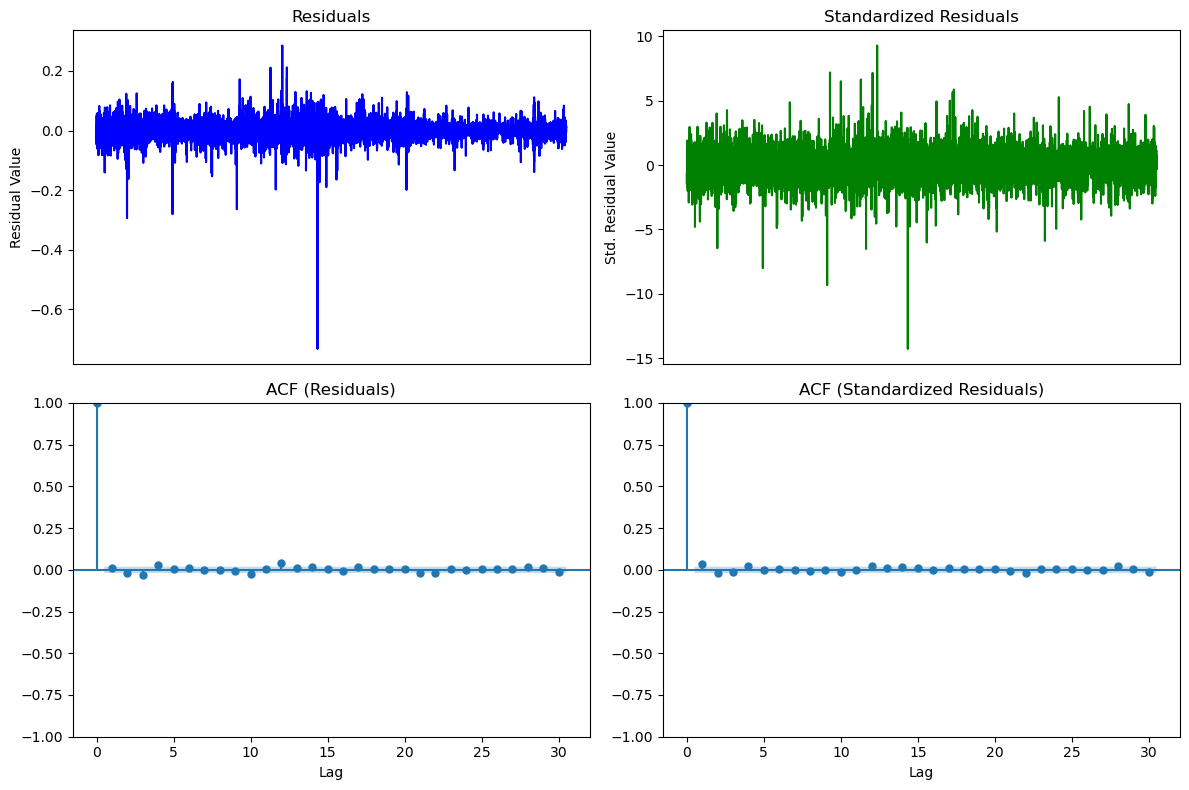

In [87]:
# Extract residuals (epsilon), conditional vol, and standardized residuals
residuals = res.resid
conditional_vol = res.conditional_volatility
standardized_residuals = residuals / conditional_vol

# ----- Plot Setup -----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Residuals vs time
axes[0, 0].plot(residuals.index, residuals, label='Residuals', color='blue')
axes[0, 0].set_title("Residuals")
axes[0, 0].set_xlabel("")  # Remove x-label
axes[0, 0].set_ylabel("Residual Value")
axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 2. Standardized residuals vs time
axes[0, 1].plot(standardized_residuals.index, standardized_residuals, label='Std Residuals', color='green')
axes[0, 1].set_title("Standardized Residuals")
axes[0, 1].set_xlabel("")  # Remove x-label
axes[0, 1].set_ylabel("Std. Residual Value")
axes[0, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 3. ACF of residuals (move this to the bottom-left position)
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title("ACF (Residuals)")
axes[1, 0].set_xlabel("Lag")  # Add x-label

# 4. ACF of standardized residuals (move this to the bottom-right position)
sm.graphics.tsa.plot_acf(standardized_residuals.dropna(), lags=30, ax=axes[1, 1])
axes[1, 1].set_title("ACF (Standardized Residuals)")
axes[1, 1].set_xlabel("Lag")  # Add x-label

plt.tight_layout()
plt.show()




In [88]:
def classify_volatilities(df, column_name, gamma):
    
    def classify_volatility(x):
        if x > gamma:
            return 1  # Positive return
        elif x < -gamma:
            return -1  # Negative return
        else:
            return 0  # Stable return
    
    df['Volatility_Label'] = df[column_name].apply(classify_volatility)
    return df

#### 2.2 Linking it to the news data
Now that we have a clean dataset to work on, let's merge our sentiment dataset with our returns dataset.

In [89]:
sentiment_data = read_file('../data/processed/processed_news_data_with_sent.csv')
sentiment_data.head()

,Date,Stock_symbol,Article_title,Sentiment
0,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...,0
1,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,...",0
2,2023-12-16 20:00:00,AAPL,AAPL Quantitative Stock Analysis,0
3,2023-12-16 04:00:00,AAPL,"After Hours Most Active for Dec 18, 2023 : PAC...",0
4,2023-12-16 04:00:00,AAPL,"Technology Sector Update for 12/18/2023: PCT, ...",0


In [90]:
#We see that news are generally published in batches
sentiment_data.drop_duplicates(["Date"])

,Date,Stock_symbol,Article_title,Sentiment
0,2023-12-16 22:00:00,AAPL,Brokers Suggest Investing in Apple (AAPL): Rea...,0
1,2023-12-16 21:00:00,AAPL,"Pre-Market Most Active for Dec 19, 2023 : BMY,...",0
2,2023-12-16 20:00:00,AAPL,AAPL Quantitative Stock Analysis,0
3,2023-12-16 04:00:00,AAPL,"After Hours Most Active for Dec 18, 2023 : PAC...",0
6,2023-12-16 02:00:00,AAPL,"Technology Sector Update for 12/18/2023: ADBE,...",0
...,...,...,...,...
2813,2020-03-14 00:00:00,AAPL,All Apple Stores Outside Of China To Temporari...,0
2814,2020-03-13 00:00:00,AAPL,Canopy Growth's Storz & Bickel Bypasses Apple'...,0
2822,2020-03-12 00:00:00,AAPL,"Technical Pro: Apple A 'Great Company,' Not A ...",0
2823,2020-03-11 00:00:00,AAPL,Apple To Close All Italy Stores Until Further ...,0


<span style="color:blue">**NEEDS RE-EVALUATION AS WE LOSE SO MUCH DATA**
</span>
 - News published after 4 PM is assigned to the next trading day

 - Sentiment data is aggregated by trading day using the mean

 - Left join with returns_data to retain only rows with both sentiment and return data

In [91]:
def process_and_merge_data(df,sentiment_data):

    # 1. Process sentiment data and assign news published after 4 PM to the next trading day
    sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], dayfirst=True)
    sentiment_data['Trading_Date'] = sentiment_data['Date'].apply(
        lambda x: (x + pd.Timedelta(days=1)).date() if x.hour >= 16 else x.date()
    )

    # 2. Process returns data
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True).dt.date

    # 3. Create daily sentiment averages because the return data is daily
    daily_sentiment = sentiment_data.groupby('Trading_Date')['Sentiment'].mean().reset_index()

    # 4. Merge sentiment with returns data
    merged_data = pd.merge(
        df,
        daily_sentiment,
        left_on='Date',
        right_on='Trading_Date',
        how='inner'
    )

    return merged_data

In [92]:
intermediate_data = process_and_merge_data(returns_data,sentiment_data)
intermediate_data.head()

C:\Users\Mert\AppData\Local\Temp\ipykernel_46148\4180739956.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], dayfirst=True)


,Date,Close,Log_Return,garch_vol,Trading_Date,Sentiment
0,2020-03-10,71.334999,0.069546,0.043953,2020-03-10,0.000000
1,2020-03-11,68.857498,-0.035348,0.046668,2020-03-11,0.142857
2,2020-03-12,62.057499,-0.103978,0.045493,2020-03-12,0.000000
3,2020-03-13,69.492500,0.113157,0.054339,2020-03-13,0.375000
4,2020-03-16,60.552502,-0.137708,0.062120,2020-03-16,-0.500000


### 3.Get transfer entropy

After we construct on the two stochastic processes $I_{t}^{s}$ and $R_{t}^{s}$, calculate the transfer entropy of the two random processes

Before we move on, we **discretize** the sentiment scores to get into the value range (-1,0,1) as we took the average when converting them into daily scores. Therefore, we are going to have an additional parameter when classifying:

$$
I_t^s =
\begin{cases} 
1, & I_t^s > \beta \quad (\text{Positive sentiment}) \\\
0, & -\beta \leq I_t^s \leq \beta \quad (\text{Neutral sentiment}) \\\
-1, & I_t^s < -\beta \quad (\text{Negative sentiment})
\end{cases}
$$

The transfer entropy is revised to be a **lagged-$\Delta$ conditional/local transfer entropy**, which $\Delta$ is the lagged time for the market participants to react on the news release, and $\lambda$ is the fixed time window on the local/conditional entropy.

$$
TE(I_{t}^{s}, R_{t+\Delta}^{s} | t - \lambda : t)
$$

Mapping the states (-1,0,1) so that there are no negative-valued states don't change the result of the transfer entropy **(detail this part)**

In [93]:
#Rediscretize the sentiment scores to calculate the TE
def discretize_sentiment_column(df, beta):
    # Apply discretization logic
    df['Sentiment_Discretized'] = np.where(
        df['Sentiment'] > beta, 1,  # Positive sentiment
        np.where(df['Sentiment'] < -beta, -1, 0)  # Negative or neutral sentiment
    )
    return df



In [94]:
def calculate_and_add_transfer_entropy(df, source_col, target_col, window_size):
    
    # Example state_mapping: change as needed
    state_mapping = {-1: 0, 0: 1, 1: 2}
    df[source_col] = df[source_col].map(state_mapping)
    df[target_col] = df[target_col].map(state_mapping)
    
    # Compute local transfer entropy
    rolling_te = transfer_entropy(
        df[source_col].to_list(),
        df[target_col].to_list(),
        k=window_size,
        local=True
    )[0]  # returns (local_te, avg_te), so [0] is local array

    # Create a new column filled with NaN
    df['Rolling_TE'] = np.nan

    # -----------------------------------------------------------
    # Align the Transfer Entropy array `rolling_te` with df.
    # Option A: Align from the START (indices 0..N-1)
    # Option B: Align at the END (indices len(df)-N..len(df)-1)
    # -----------------------------------------------------------
    
    N = len(rolling_te)
    D = len(df)

    # Safety check: if rolling_te is longer than df, handle that
    if N > D:
        # Possibly truncate or raise an error; here we just keep the last D points
        rolling_te = rolling_te[-D:]
        N = D

    # Example: Align at the END by default
    df.loc[df.index[-N:], 'Rolling_TE'] = rolling_te
    
    return df


### 4. Design trading strategy

Based on the sentiment process $I_{s}^{t}$ and the transfer entropy $TE(I_{t}^{s}, R_{t+\Delta}^{s} | t - \lambda : t)$ , design a statistic arbitrage trading strategy **(only one idea)** as follows:

````python
if (sentiment_score > 0) & (TE>threshold):
    buy stock at time t
    sell stock at time t + delta
elif (sentiment_score < 0) & (TE>threshold):
    short sell stock at time t
    buy back stock at time t + delta
else:
    continue
````

The ``threshold`` can be written as $\alpha$ for further demonstration.

The strategy can be also revised to be a long-short strategy.

In [95]:
# Define the trading strategy function
def apply_trading_strategy(df, alpha, delta):
    # For the optimization pipeline to work (prevent index breaking)
    df = df.reset_index(drop=True)
    df['Strategy_Return'] = 0.0  # Initialize column for strategy returns as float
    
    for t in range(len(df) - delta):
        sentiment_score = df.loc[t, 'Sentiment']
        te = df.loc[t, 'Rolling_TE']
        
        # Check trading conditions
        if pd.notnull(te) and (sentiment_score > 0) and (te > alpha):
            df.loc[t + delta, 'Strategy_Return'] = df.loc[t + delta, 'Log_Return']
        elif pd.notnull(te) and (sentiment_score < 0) and (te > alpha):
            df.loc[t + delta, 'Strategy_Return'] = -df.loc[t + delta, 'Log_Return']
    
    # Calculate cumulative return
    df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()
    
    return df

In [96]:
# Initial values of the parameters
initial_gamma = 0.022
beta_initial = 0.3
delta_return_initial = 7
lambda_initial = 2
alpha_initial = 0.1

# Define transformations as a list of (function, arguments)
transformations = [
    (classify_volatilities, {
                        'column_name' : 'garch_vol', 
                        'gamma' : initial_gamma
                        }
                            ),

    #(process_and_merge_data, {'sentiment_data' : sentiment_data}),

    (discretize_sentiment_column, {'beta': beta_initial}),

    (calculate_and_add_transfer_entropy, {  
                                        'source_col': 'Sentiment_Discretized', 
                                        'target_col': 'Volatility_Label', 
                                        'window_size': lambda_initial,
                                            }
                                                ),

    (apply_trading_strategy, {
                            'alpha':alpha_initial,
                            'delta':delta_return_initial
                            }
                                )
    
]

In [97]:
#Applying the pipeline
final_df = optimization_pipeline(intermediate_data, transformations)
final_df

,Date,Close,Log_Return,garch_vol,Trading_Date,Sentiment,Volatility_Label,Sentiment_Discretized,Rolling_TE,Strategy_Return,Cumulative_Return
0,2020-03-10,71.334999,0.069546,0.043953,2020-03-10,0.000000,2,1,NaN,0.000000,1.000000
1,2020-03-11,68.857498,-0.035348,0.046668,2020-03-11,0.142857,2,1,NaN,0.000000,1.000000
2,2020-03-12,62.057499,-0.103978,0.045493,2020-03-12,0.000000,2,1,-0.007389,0.000000,1.000000
3,2020-03-13,69.492500,0.113157,0.054339,2020-03-13,0.375000,2,2,-0.007389,0.000000,1.000000
4,2020-03-16,60.552502,-0.137708,0.062120,2020-03-16,-0.500000,2,0,0.078003,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
211,2023-01-23,141.110001,0.023229,0.018618,2023-01-23,0.200000,1,1,0.037968,0.000000,1.029200
212,2023-01-24,142.529999,0.010013,0.019188,2023-01-24,0.000000,1,1,0.037968,0.000000,1.029200
213,2023-01-25,141.860001,-0.004712,0.018641,2023-01-25,0.166667,1,1,0.037968,0.000000,1.029200
214,2023-01-26,143.960007,0.014695,0.018061,2023-01-26,0.250000,1,1,0.037968,0.014695,1.044324


### 5. Calibration and train-validation-test split

Based on the arbitrage strategy, we have several hyperparameters to be calibrated: $\delta, \gamma, \Delta, \lambda, \alpha$. The hyperparameters should be calibrated using the in-sample training set and validation set, and perform stimulation trading on the out-of-sample test set. The size of the whole train-validation-test set should be fixed and moved along the time with the moving interval to be the exact size of the test set, only using the most recent data and construct a trading performance over the whole dataframe.

Within one single train-validation-test set, the best hyperparameters for each stock $s$ are found based on the Sharpe ratio of the strategy in the **validation set**. The way of finding the best hyperparameters should be done by grid search.

**Important**: When calibrating the model use **memoisation** techniques to notice the time-difference

In [98]:
def calculate_sharpe_ratio(df, return_column='Strategy_Return'):
    """
    Calculates the Sharpe ratio for the strategy returns in `return_column`.
    """
    returns = df[return_column]
    mean_return = returns.mean()
    std_dev = returns.std()
    if std_dev == 0:
        return 0
    return mean_return / std_dev


In [99]:
def optimize_params_func(train_set, val_set, initial_params, num_points, transformations):
    """
    Example grid search to find best hyperparameters for the strategy,
    picking those that maximize the Sharpe ratio on the validation set.

    Returns:
      best_params (dict)
      best_val_sharpe (float)
    """

    # Define your search space:
    gamma_values = [0.022, 0.025 ,0.028, 0.03]
    beta_values = [0.3, 0.5]
    delta_values = [1, 2 ,3 ,4 , 5, 6, 7]
    lambda_values = [2, 4]
    alpha_values = [0.1, 0.2, 0.3]

    # Number of equally spaced intervals for each parameter

    # Generate equally spaced intervals
    #gamma_values = np.linspace(0.04, 0.1, num_points)  # Float
    #beta_values = np.linspace(0.3, 0.5, num_points)  # Float
    #delta_values = np.linspace(1, 2, num_points).astype(int)  # Integer
    #lambda_values = np.linspace(2, 4, num_points).astype(int)  # Integer
    #alpha_values = np.linspace(0.1, 0.2, num_points)  # Float

    # Ensure uniqueness in integers (if needed, for small ranges)
    #delta_values = np.unique(delta_values)
    #lambda_values = np.unique(lambda_values)
    
    best_val_sharpe = -np.inf
    best_params = dict(initial_params)
    
    for gamma in gamma_values:
        for beta in beta_values:
            for delta_ in delta_values:
                for lambda_ in lambda_values:
                    for alpha_ in alpha_values:
                        # Build transformations for train/val
                        current_transformations = [
                            (classify_volatilities, {
                                'column_name': 'garch_vol',
                                'gamma': gamma
                            }),
                            (discretize_sentiment_column, {
                                'beta': beta
                            }),
                            (calculate_and_add_transfer_entropy, {
                                'source_col': 'Sentiment_Discretized',
                                'target_col': 'Volatility_Label',
                                'window_size': lambda_,
                            }),
                            (apply_trading_strategy, {
                                'alpha': alpha_,
                                'delta': delta_
                            })
                        ]

                        # (Optional) "Train" on train_set if there's a model to fit;
                        # if purely rule-based, we just skip or run the pipeline anyway:
                        _ = optimization_pipeline(train_set.copy(), current_transformations)

                        # Evaluate on val_set
                        val_df = optimization_pipeline(val_set.copy(), current_transformations)
                        val_sharpe = calculate_sharpe_ratio(val_df)

                        if val_sharpe > best_val_sharpe:
                            best_val_sharpe = val_sharpe
                            best_params = {
                                'gamma': gamma,
                                'beta': beta,
                                'delta': delta_,
                                'lambda': lambda_,
                                'alpha': alpha_
                            }
    
    return best_params, best_val_sharpe


In [100]:

def rolling_calibration_single_bar_summary(
    data,
    transformations,
    initial_params,
    num_points,
    window_size,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=None
):
    """
    Rolling calibration that:
      - Shows ONE progress bar for the rolling windows
      - Runs grid search inside `optimize_params_func` (no bar)
      - Stores ONE summary row per rolling window
    """

    num_points = len(data)
    
    # Indices for splitting within each window
    train_end = int(train_ratio * window_size)
    val_end   = int((train_ratio + val_ratio) * window_size)
    # Test slice is from val_end to window_size

    # 1) Determine how many rolling windows
    num_windows = 0
    start_idx = 0
    while start_idx + window_size <= num_points:
        num_windows += 1
        start_idx += step_size

    # We'll store the summary rows in a list
    summaries = []

    # Reset start_idx for the actual loop
    start_idx = 0

    with tqdm(total=num_windows, desc="Rolling Calibration (One Bar)") as pbar:
        while start_idx + window_size <= num_points:
            # Slice the rolling window
            window_data = data.iloc[start_idx : start_idx + window_size].copy()

            # Split into train/val/test
            train_set = window_data.iloc[:train_end]
            val_set   = window_data.iloc[train_end:val_end]
            test_set  = window_data.iloc[val_end:window_size]

            # 2) Grid search on (train, val) to find best_params + best_val_sharpe
            best_params, best_val_sharpe = optimize_params_func(
                train_set,
                val_set,
                initial_params,
                num_points,
                transformations
            )

            # 3) Apply best_params to the test set
            final_transformations = [
                (classify_volatilities, {
                    'column_name': 'garch_vol',
                    'gamma': best_params['gamma']
                }),
                (discretize_sentiment_column, {
                    'beta': best_params['beta']
                }),
                (calculate_and_add_transfer_entropy, {
                    'source_col': 'Sentiment_Discretized',
                    'target_col': 'Volatility_Label',
                    'window_size': best_params['lambda'],
                }),
                (apply_trading_strategy, {
                    'alpha': best_params['alpha'],
                    'delta': best_params['delta']
                })
            ]
            test_df = optimization_pipeline(test_set.copy(), final_transformations)

            # 4) Evaluate test performance
            test_sharpe = calculate_sharpe_ratio(test_df)

            # Optionally compute mean or cumulative returns
            mean_return = test_df['Strategy_Return'].mean()
            cum_return = (1 + test_df['Strategy_Return']).prod() - 1

            # 5) Create a SINGLE summary row for this window
            summary_row = {
                'start_idx': start_idx,
                'best_params': str(best_params),
                'best_val_sharpe': best_val_sharpe,
                'test_sharpe': test_sharpe,
                'test_mean_return': mean_return,
                'test_cum_return': cum_return
            }
            summaries.append(summary_row)

            # Move the rolling window
            start_idx += step_size
            pbar.update(1)  # single bar update

    # Convert summary rows to DataFrame
    summary_df = pd.DataFrame(summaries)
    return summary_df


In [101]:
# Example usage:
transformations = []  # if you have extra steps to do outside the param search
initial_params = {
    'gamma': 0.04,
    'beta': 0.3,
    'delta': 1,
    'lambda': 2,
    'alpha': 0.2
}

summary_df = rolling_calibration_single_bar_summary(
    data=intermediate_data,
    transformations=transformations,
    initial_params=initial_params,
    num_points = 1,
    window_size=100,
    step_size=1,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    optimize_params_func=optimize_params_func
)

Rolling Calibration (One Bar): 100%|██████████| 117/117 [02:48<00:00,  1.44s/it]


In [102]:
summary_df

,start_idx,best_params,best_val_sharpe,test_sharpe,test_mean_return,test_cum_return
0,0,"{'gamma': 0.028, 'beta': 0.3, 'delta': 7, 'lam...",0.460754,0.000000,0.000000,0.000000
1,1,"{'gamma': 0.028, 'beta': 0.3, 'delta': 5, 'lam...",0.399509,0.000000,0.000000,0.000000
2,2,"{'gamma': 0.025, 'beta': 0.3, 'delta': 5, 'lam...",0.393876,0.000000,0.000000,0.000000
3,3,"{'gamma': 0.025, 'beta': 0.3, 'delta': 5, 'lam...",0.393876,0.000000,0.000000,0.000000
4,4,"{'gamma': 0.025, 'beta': 0.3, 'delta': 5, 'lam...",0.393876,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
112,112,"{'gamma': 0.025, 'beta': 0.3, 'delta': 2, 'lam...",0.460696,0.223607,0.001807,0.036133
113,113,"{'gamma': 0.025, 'beta': 0.3, 'delta': 1, 'lam...",0.404166,-0.206839,-0.000867,-0.017360
114,114,"{'gamma': 0.025, 'beta': 0.3, 'delta': 2, 'lam...",0.441578,0.223607,0.001807,0.036133
115,115,"{'gamma': 0.025, 'beta': 0.3, 'delta': 2, 'lam...",0.491943,0.223607,0.001807,0.036133


### To-do
 - Incorporate different NLP models
    - Add the optimized code for DISTILL-ROBERTA
 - Adding other stocks to the pipeline

### Plots

c:\Users\Mert\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


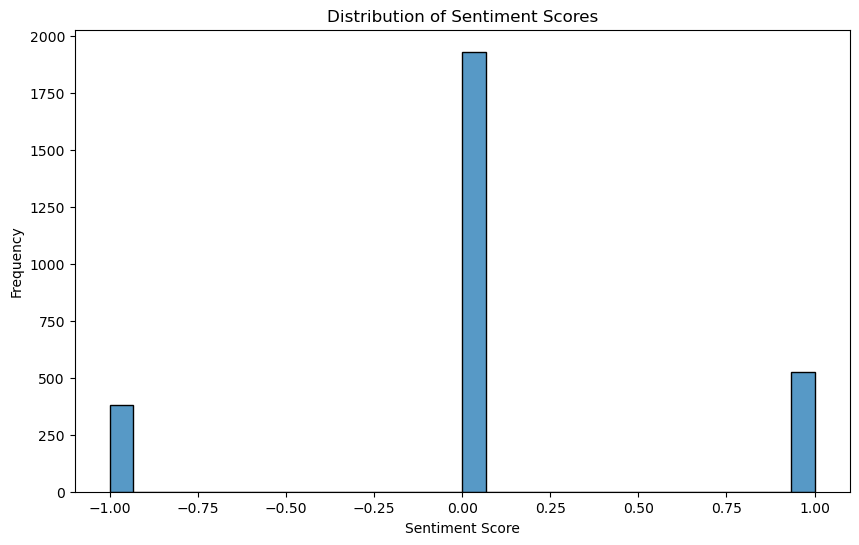

In [103]:
sent_df = pd.read_csv("../data/processed/processed_news_data_with_sent.csv")

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(sent_df['Sentiment'], bins=30)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

C:\Users\Mert\AppData\Local\Temp\ipykernel_46148\335439001.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sentiment_data['Date'] = pd.to_datetime(filtered_sentiment_data['Date'])
C:\Users\Mert\AppData\Local\Temp\ipykernel_46148\335439001.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sentiment_data['Trading_Date'] = filtered_sentiment_data['Date'].apply(
c:\Users\Mert\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will 

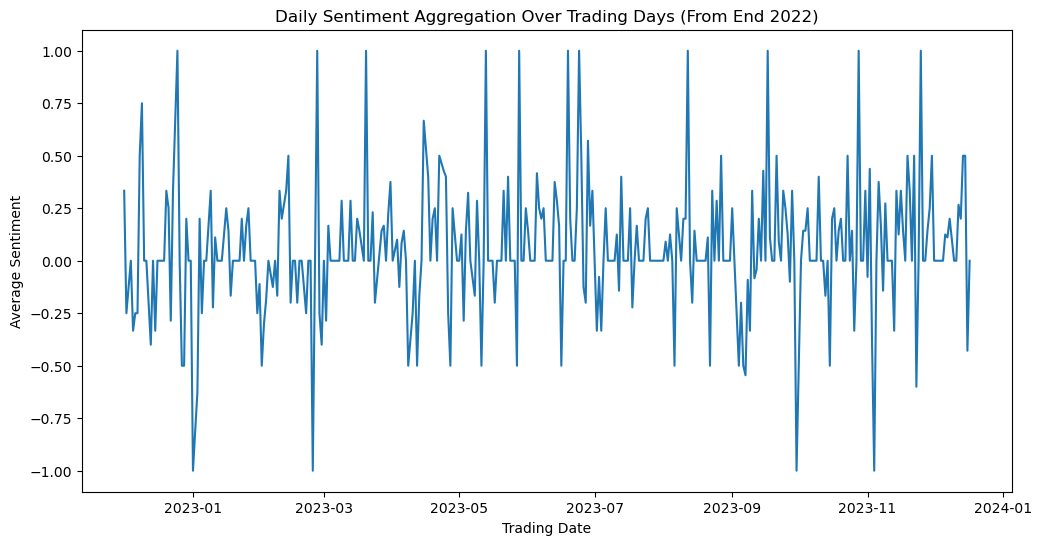

c:\Users\Mert\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mert\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


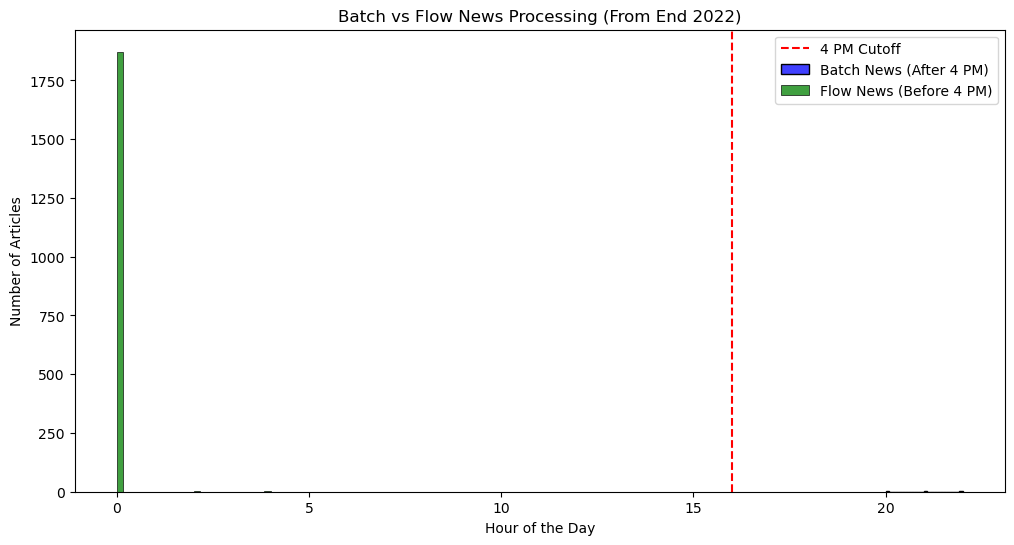

In [104]:
# Filter data to include only from the end of 2022
start_date = '2022-12-01'
filtered_sentiment_data = sentiment_data[sentiment_data['Date'] >= start_date]

# Ensure sentiment_data is in datetime format
filtered_sentiment_data['Date'] = pd.to_datetime(filtered_sentiment_data['Date'])

# Define daily sentiment by shifting the news released after 4pm to the next day
filtered_sentiment_data['Trading_Date'] = filtered_sentiment_data['Date'].apply(
	lambda x: (x + pd.Timedelta(days=1)).date() if x.hour >= 16 else x.date()
)
#Taking the mean of the sentiments
filtered_daily_sentiment = filtered_sentiment_data.groupby('Trading_Date')['Sentiment'].mean().reset_index()
filtered_daily_sentiment.head()


# Effect of sentiment aggregation on trading days
plt.figure(figsize=(12, 6))
filtered_daily_sentiment['Trading_Date'] = pd.to_datetime(filtered_daily_sentiment['Trading_Date'])
sns.lineplot(data=filtered_daily_sentiment, x='Trading_Date', y='Sentiment')
plt.title('Daily Sentiment Aggregation Over Trading Days (From End 2022)')
plt.xlabel('Trading Date')
plt.ylabel('Average Sentiment')
plt.show()

# Examples of batch vs flow news processing
batch_news = filtered_sentiment_data[filtered_sentiment_data['Date'].dt.hour >= 16]
flow_news = filtered_sentiment_data[filtered_sentiment_data['Date'].dt.hour < 16]

plt.figure(figsize=(12, 6))
sns.histplot(batch_news['Date'].dt.hour, bins=24, kde=False, color='blue', label='Batch News (After 4 PM)')
sns.histplot(flow_news['Date'].dt.hour, bins=24, kde=False, color='green', label='Flow News (Before 4 PM)')
plt.axvline(x=16, color='r', linestyle='--', label='4 PM Cutoff')
plt.title('Batch vs Flow News Processing (From End 2022)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

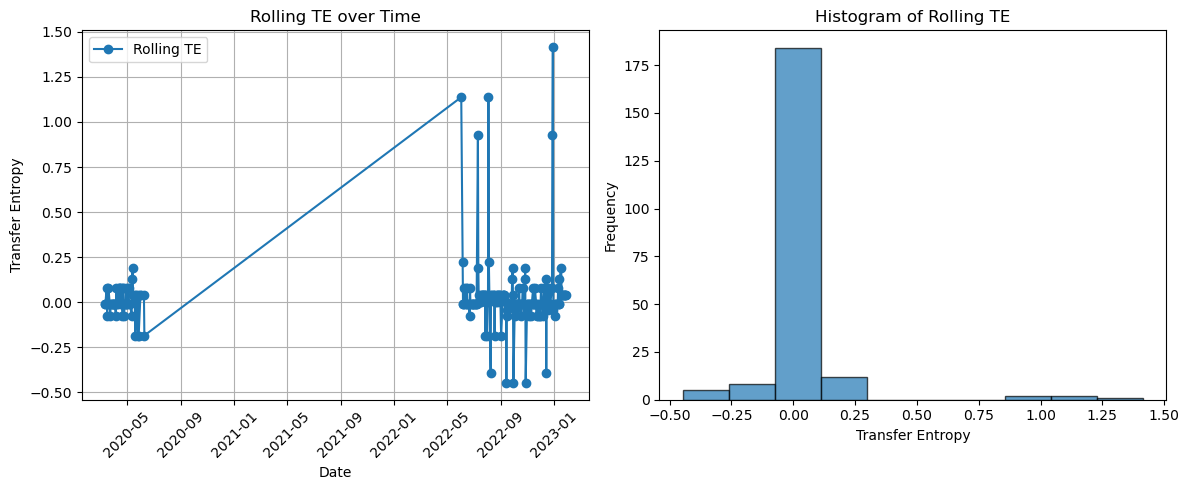

In [105]:
# Plot Rolling_TE over time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Line plot
axes[0].plot(final_df['Date'], final_df['Rolling_TE'], marker='o', label='Rolling TE')
axes[0].set_title("Rolling TE over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Transfer Entropy")
axes[0].grid(True)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45) 

# Histogram
axes[1].hist(final_df['Rolling_TE'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1].set_title("Histogram of Rolling TE")
axes[1].set_xlabel("Transfer Entropy")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

<span style="color:blue">**Important observation**</span>: Notice there **no values** between 2020-06-10 and 2022-06-03

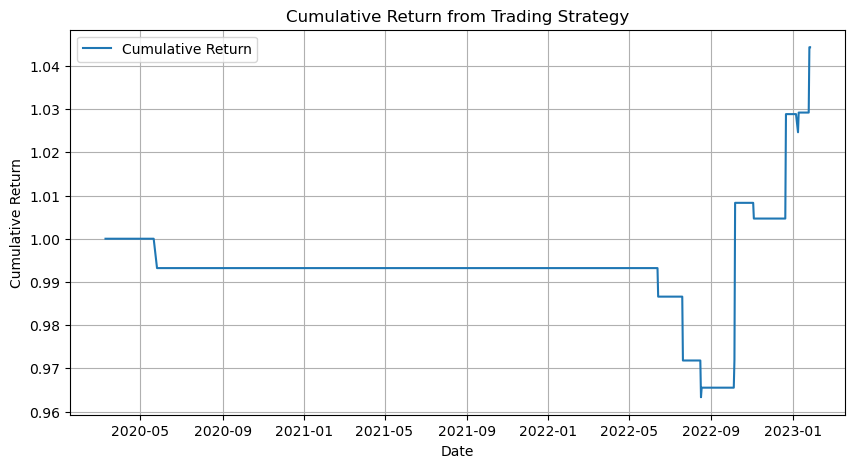

In [106]:
# Plot cumulative return
plt.figure(figsize=(10, 5))
plt.plot(final_df['Date'], final_df['Cumulative_Return'], label='Cumulative Return')
plt.title('Cumulative Return from Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()